# Training of the CNN model and testing on the holdout test data partition (20-fold cross-validation)

In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('hippocampus_volume_relevance_ADNI2.xlsx', sheet_name='ADNI2_LRP_CMP')
sid = df['subject_ID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV_CAT12']
field = df['MRI_Field_Strength']
amybin = df['Amy SUVR Pos']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataAD = sorted(glob.glob('mwp1_MNI/AD/*.nii.gz'))
dataLMCI = sorted(glob.glob('mwp1_MNI/LMCI/*.nii.gz'))
dataCN = sorted(glob.glob('mwp1_MNI/CN/*.nii.gz'))
dataFiles = dataAD + dataLMCI + dataCN
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  663  nifti files


In [3]:
# Match covariate information
import re
import numpy as np
from keras.utils import to_categorical
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Using TensorFlow backend.


Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
from pandas import DataFrame
hf = h5py.File('residuals_ADNI2_wb_mwp1_CAT12_MNI.hdf5', 'r')
hf.keys # read keys
images = np.array(hf.get('images'))
hf.close()
print(images.shape)

(663, 100, 100, 120, 1)


In [5]:
# specify version of tensorflow
#%tensorflow_version 1.x  # <- use this for Google colab
import tensorflow as tf
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
print(tf.__version__)

# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

1.15.4


In [6]:
# define function for simple data augmentation (translation of 2 vx in each x/y/z direction)
# and L/R flipping
import numpy as np
def simpleshift(arr, num, axis, fill_value=0): # adapted from https://stackoverflow.com/a/42642326
  result = np.empty_like(arr)
  if (axis==1):
    if num > 0:
        result[:, :num, :, :, :] = fill_value
        result[:, num:, :, :, :] = arr[:, :-num, :, :, :]
    elif num < 0:
        result[:, num:, :, :, :] = fill_value
        result[:, :num, :, :, :] = arr[:, -num:, :, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==2):
    if num > 0:
        result[:, :, :num, :, :] = fill_value
        result[:, :, num:, :, :] = arr[:, :, :-num, :, :]
    elif num < 0:
        result[:, :, num:, :, :] = fill_value
        result[:, :, :num, :, :] = arr[:, :, -num:, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==3):
    if num > 0:
        result[:, :, :, :num, :] = fill_value
        result[:, :, :, num:, :] = arr[:, :, :, :-num, :]
    elif num < 0:
        result[:, :, :, num:, :] = fill_value
        result[:, :, :, :num, :] = arr[:, :, :, -num:, :]
    else:
        result[:] = arr
    return result
  else:
    return None

In [7]:
# helper function to obtain performance result values
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((ppv * sen) / (ppv + sen))
    bacc = (spec + sen) / 2
    return bacc, sen, spec, ppv, npv, f1

In [8]:
# define class weights to train a balanced model, taken from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(labels[:, 1].astype(np.int_))
weight_for_0 = (1 / neg)*(numfiles)/2.0 
weight_for_1 = (1 / pos)*(numfiles)/2.0
class_weights = {0: weight_for_0, 1: weight_for_1}
print('Examples:    Total: {}    Positive: {} ({:.2f}% of total)'.format(
    numfiles, pos, 100 * pos / numfiles))
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:    Total: 663    Positive: 409 (61.69% of total)
Weight for class 0: 1.31
Weight for class 1: 0.81


Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    228
3    198
4    170
Name: Group, dtype: int64
[5165, 5187, 101, 42, 5241, 1010, 5146, 378, 1427, 5056, 230, 4990, 4373, 4568, 4657, 4660, 4692, 4863, 4984, 4115, 307, 150, 1418, 671, 1269, 107, 6056, 4034, 4035, 4214, 4287, 4303, 4346, 4359, 4363, 4510, 4595, 4629, 4722, 4896, 4960, 4105, 96, 56, 210, 5023, 352, 89, 1261, 4010, 4014, 4075, 4103, 4179, 4224, 4278, 4337, 4382, 4400, 4410, 4422, 4464, 4576, 4585, 4616, 4645, 4843]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    19
Name: Group, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 100, 100, 120, 5)  140       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 50, 60, 5)     0         
_______________________________________________

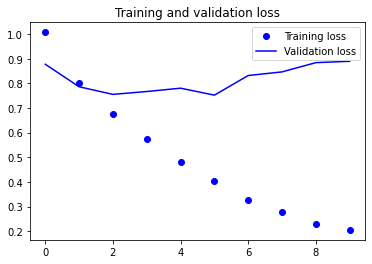

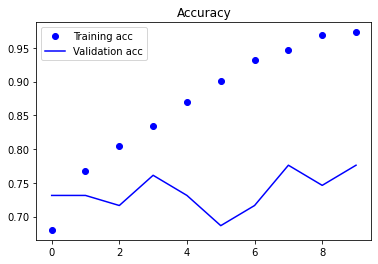

validating model model_checkpoints/resmodel_wb_cv1.best.hdf5
67/67 [==============================] - 1s 11ms/step
Test acc: 77.61%


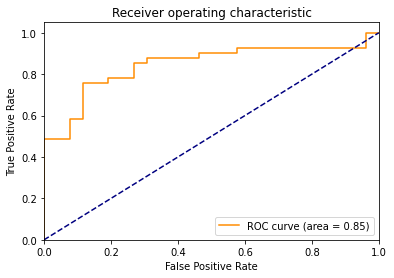

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.781
AUC for AD vs. CN = 0.919
confusion matrix
[[21  5]
 [ 0  0]
 [ 7 15]
 [ 3 16]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    228
3    198
4    170
Name: Group, dtype: int64
[702, 5251, 376, 906, 5063, 5162, 5062, 269, 51, 4992, 5058, 873, 1255, 6142, 4252, 4549, 4783, 4827, 4954, 908, 4543, 1046, 4945, 4630, 1226, 5047, 1300, 200, 123, 1414, 1186, 4030, 4077, 4131, 4197, 4366, 4515, 4605, 4777, 4782, 4955, 1190, 479, 1016, 4050, 260, 545, 301, 668, 6051, 4021, 4086, 4093, 4148, 4196, 4262, 4269, 4343, 4348, 4365, 4367, 4474, 4483, 4505, 4516, 4599, 4612]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    19
Name: Group, dtype: int64
Train on 8344 samples, validate on 67 samples
Epoch 1/10
8344/8344 [==============================] - 193s 23ms/step - loss: 0.9847 - acc: 0.6971 - val_loss:

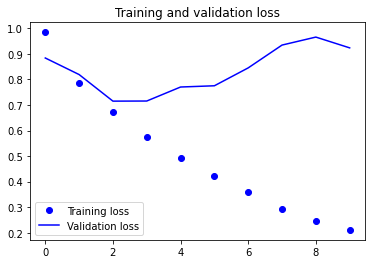

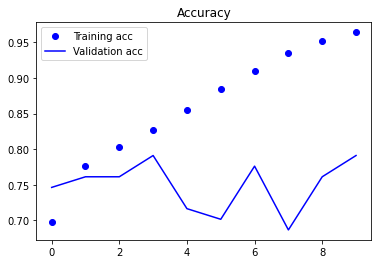

validating model model_checkpoints/resmodel_wb_cv2.best.hdf5
67/67 [==============================] - 1s 13ms/step
Test acc: 79.10%


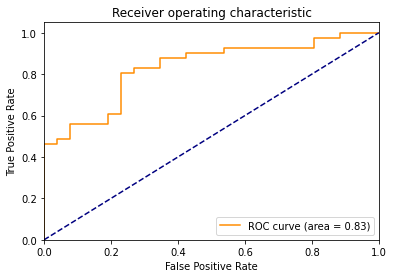

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.753
AUC for AD vs. CN = 0.921
confusion matrix
[[19  7]
 [ 0  0]
 [ 6 16]
 [ 1 18]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    228
3    198
4    170
Name: Group, dtype: int64
[5119, 5037, 5252, 5240, 552, 1425, 5070, 5090, 5015, 973, 4089, 4195, 4258, 4477, 4526, 4732, 4755, 4772, 4867, 4229, 1122, 420, 4922, 644, 4729, 1318, 454, 1408, 4250, 717, 6297, 4015, 4053, 4061, 4169, 4240, 4524, 4562, 4857, 4889, 4976, 4213, 4872, 1206, 4097, 734, 1098, 934, 4234, 896, 657, 186, 4032, 4043, 4092, 4100, 4121, 4151, 4288, 4369, 4372, 4376, 4559, 4577, 4649, 4832, 4855]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    19
Name: Group, dtype: int64
Train on 8344 samples, validate on 67 samples
Epoch 1/10
8344/8344 [==============================] - 194s 23ms/step - loss: 1.0602 - acc: 0.6636 - val_l

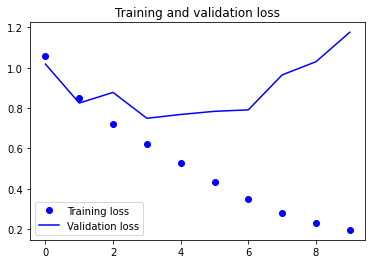

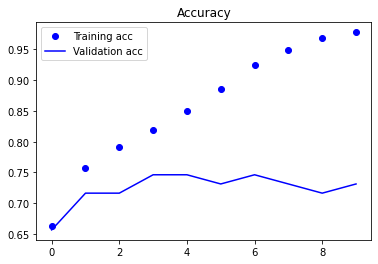

validating model model_checkpoints/resmodel_wb_cv3.best.hdf5
67/67 [==============================] - 1s 14ms/step
Test acc: 74.63%


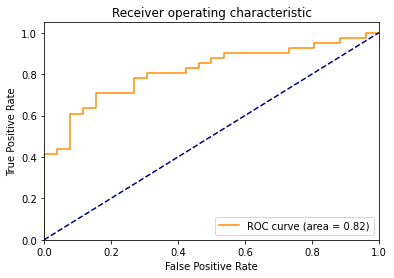

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.741
AUC for AD vs. CN = 0.901
confusion matrix
[[21  5]
 [ 0  0]
 [10 12]
 [ 2 17]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    229
3    198
4    170
Name: Group, dtype: int64
[572, 1030, 6303, 1326, 830, 5087, 997, 5059, 5138, 4215, 4223, 4307, 4672, 4696, 4730, 4770, 4792, 4912, 4962, 4985, 142, 6356, 1045, 4203, 4714, 1380, 4167, 1419, 778, 6274, 4219, 4243, 4293, 4414, 4444, 4646, 4736, 4769, 4815, 4888, 4904, 4270, 610, 498, 842, 985, 920, 171, 113, 4037, 4084, 4275, 4340, 4349, 4393, 4401, 4469, 4482, 4485, 4503, 4545, 4566, 4598, 4609, 4762, 4835]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
Train on 8358 samples, validate on 66 samples
Epoch 1/10
8358/8358 [==============================] - 199s 24ms/step - loss: 1.0140 - acc: 0.6858 - val_loss: 0.

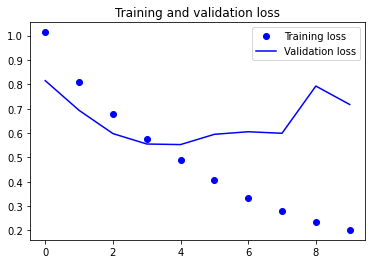

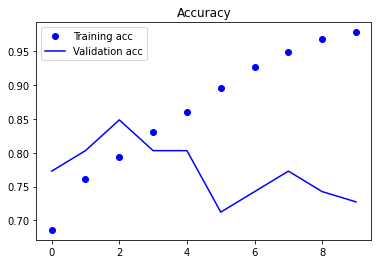

validating model model_checkpoints/resmodel_wb_cv4.best.hdf5
66/66 [==============================] - 1s 16ms/step
Test acc: 84.85%


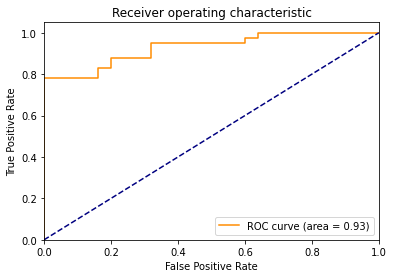

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.896
AUC for AD vs. CN = 0.966
confusion matrix
[[24  1]
 [ 0  0]
 [ 8 14]
 [ 1 18]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    229
3    198
4    170
Name: Group, dtype: int64
[1130, 408, 292, 4859, 4968, 5184, 4009, 4024, 4039, 4152, 4153, 4201, 4546, 4589, 4591, 4641, 4774, 4911, 5012, 6258, 546, 6427, 1218, 1072, 746, 4311, 296, 4542, 4029, 4058, 4122, 4170, 4395, 4596, 4636, 4689, 4713, 4723, 4743, 4757, 4925, 419, 159, 58, 61, 120, 59, 1232, 272, 969, 1195, 1202, 4173, 4225, 4290, 4308, 4313, 4399, 4604, 4607, 4620, 4644, 4652, 4856, 4951, 4952]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
Train on 8358 samples, validate on 66 samples
Epoch 1/10
8358/8358 [==============================] - 195s 23ms/step - loss: 0.9487 - acc: 0.7004 - val_loss: 0.9079

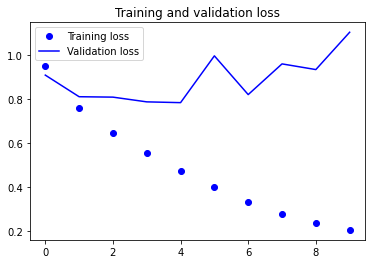

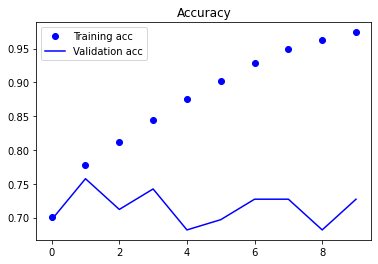

validating model model_checkpoints/resmodel_wb_cv5.best.hdf5
66/66 [==============================] - 1s 18ms/step
Test acc: 75.76%


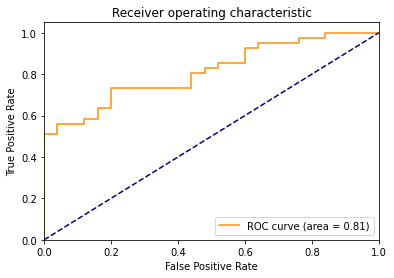

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.667
AUC for AD vs. CN = 0.981
confusion matrix
[[20  5]
 [ 0  0]
 [11 11]
 [ 0 19]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    229
3    198
4    170
Name: Group, dtype: int64
[5038, 887, 4964, 5013, 5017, 4980, 1346, 5029, 667, 6039, 5231, 5275, 4379, 4583, 4737, 4905, 4906, 4982, 5019, 4804, 679, 919, 4300, 800, 1268, 4042, 4094, 4138, 4210, 4244, 4458, 4582, 4654, 4741, 4767, 4793, 4873, 4885, 4929, 4936, 4943, 618, 173, 229, 863, 722, 767, 4255, 1280, 4026, 4041, 4076, 4125, 4155, 4177, 4292, 4345, 4352, 4391, 4441, 4555, 4637, 4638, 4643, 4878, 4900]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
Train on 8358 samples, validate on 66 samples
Epoch 1/10
8358/8358 [==============================] - 197s 24ms/step - loss: 1.0214 - acc: 0.6391 - val_loss: 0

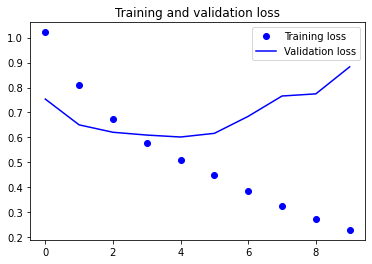

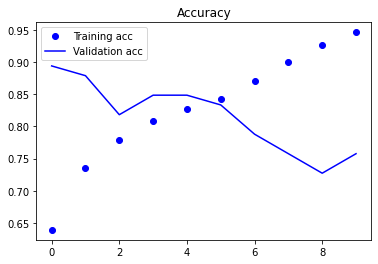

validating model model_checkpoints/resmodel_wb_cv6.best.hdf5
66/66 [==============================] - 1s 20ms/step
Test acc: 89.39%


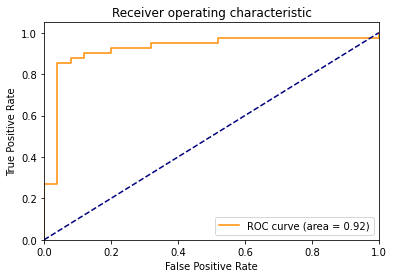

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.873
AUC for AD vs. CN = 0.979
confusion matrix
[[24  1]
 [ 0  0]
 [ 6 16]
 [ 0 19]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    229
3    198
4    170
Name: Group, dtype: int64
[5196, 5027, 5071, 1117, 5112, 5005, 4959, 4994, 5106, 166, 5028, 135, 1043, 4136, 4686, 4820, 4887, 4910, 4940, 6073, 1063, 867, 4899, 1118, 925, 4928, 505, 1052, 4263, 4324, 4381, 4406, 4430, 4502, 4521, 4626, 4721, 4746, 4750, 4784, 4877, 907, 981, 553, 130, 31, 926, 741, 257, 172, 21, 413, 4080, 4090, 4174, 4218, 4276, 4320, 4350, 4371, 4385, 4388, 4396, 4488, 4558, 4921]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
Train on 8358 samples, validate on 66 samples
Epoch 1/10
8358/8358 [==============================] - 197s 24ms/step - loss: 1.0052 - acc: 0.6590 - val_loss: 0.7278 -

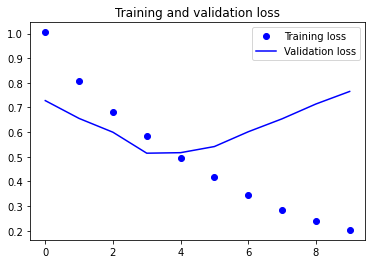

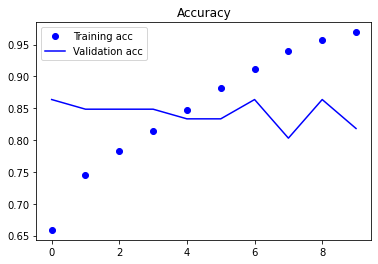

validating model model_checkpoints/resmodel_wb_cv7.best.hdf5
66/66 [==============================] - 1s 22ms/step
Test acc: 86.36%


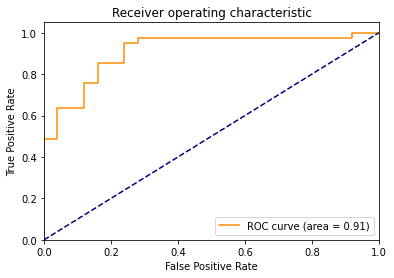

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.869
AUC for AD vs. CN = 0.960
confusion matrix
[[19  6]
 [ 0  0]
 [ 3 19]
 [ 0 19]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    229
3    198
4    170
Name: Group, dtype: int64
[5057, 331, 214, 5067, 5095, 5123, 4971, 5006, 994, 1004, 4001, 4209, 4280, 4282, 4353, 4500, 4718, 4879, 4894, 1155, 6334, 872, 291, 1106, 709, 1246, 6180, 4294, 4394, 4402, 4408, 4426, 4507, 4584, 4611, 4668, 4671, 4712, 4720, 4842, 4852, 751, 4208, 69, 1286, 112, 886, 4028, 4060, 4082, 4200, 4222, 4277, 4386, 4429, 4446, 4449, 4496, 4499, 4520, 4552, 4560, 4578, 4579, 4580, 4795]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
Train on 8358 samples, validate on 66 samples
Epoch 1/10
8358/8358 [==============================] - 197s 24ms/step - loss: 0.9828 - acc: 0.7048 - val_loss: 0

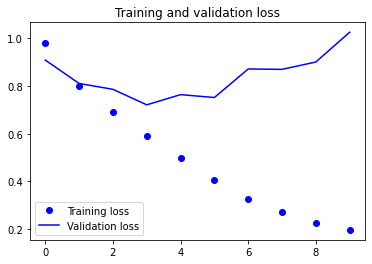

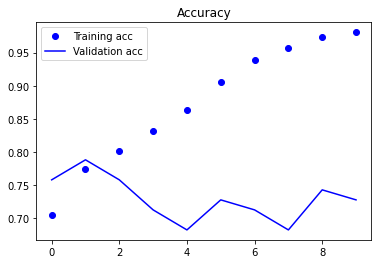

validating model model_checkpoints/resmodel_wb_cv8.best.hdf5
66/66 [==============================] - 2s 24ms/step
Test acc: 78.79%


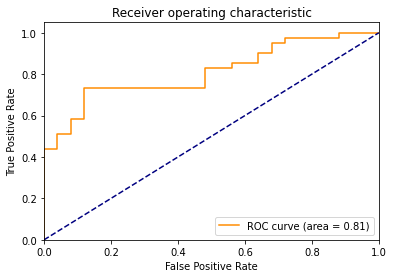

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.695
AUC for AD vs. CN = 0.943
confusion matrix
[[22  3]
 [ 0  0]
 [10 12]
 [ 1 18]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    229
3    198
4    170
Name: Group, dtype: int64
[1057, 5224, 658, 5032, 5120, 5054, 835, 5210, 5208, 1007, 4997, 4192, 4494, 4615, 4676, 4707, 4719, 4801, 4845, 4251, 1074, 4194, 1169, 989, 1187, 4189, 6336, 4057, 4079, 4171, 4354, 4377, 4403, 4531, 4590, 4711, 4807, 4817, 4903, 4909, 4989, 984, 74, 923, 5040, 315, 680, 4198, 4003, 4066, 4104, 4119, 4120, 4139, 4158, 4164, 4266, 4335, 4357, 4384, 4421, 4424, 4453, 4491, 4508, 4688]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
Train on 8358 samples, validate on 66 samples
Epoch 1/10
8358/8358 [==============================] - 198s 24ms/step - loss: 1.0524 - acc: 0.6662 - val_loss:

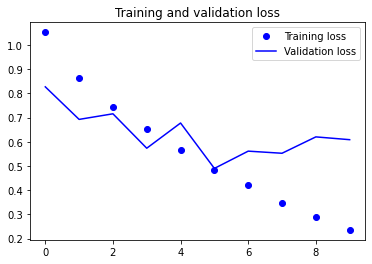

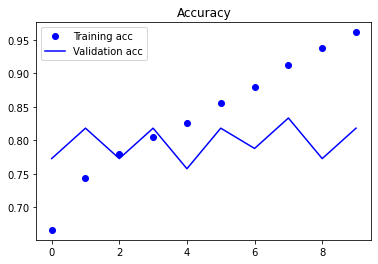

validating model model_checkpoints/resmodel_wb_cv9.best.hdf5
66/66 [==============================] - 2s 26ms/step
Test acc: 83.33%


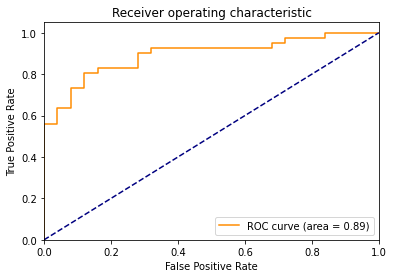

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    25
3    22
4    19
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.820
AUC for AD vs. CN = 0.979
confusion matrix
[[22  3]
 [ 0  0]
 [ 7 15]
 [ 1 18]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    228
3    198
4    171
Name: Group, dtype: int64
[729, 4924, 5205, 5016, 160, 361, 227, 4172, 4211, 4338, 4501, 4625, 4728, 4756, 4802, 4853, 4949, 5018, 698, 4302, 285, 1378, 4187, 4096, 4114, 4162, 4456, 4462, 4489, 4538, 4548, 4631, 4653, 4675, 4715, 4806, 4869, 4892, 4902, 4918, 23, 1352, 47, 295, 311, 4018, 4020, 4081, 4150, 4176, 4254, 4279, 4291, 4339, 4387, 4389, 4427, 4428, 4433, 4448, 4466, 4506, 4586, 4587, 4632, 4739]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    18
Name: Group, dtype: int64
Train on 8358 samples, validate on 66 samples
Epoch 1/10
8358/8358 [==============================] - 198s 24ms/step - loss: 1.0234 - acc: 0.6700 - val_loss: 1.

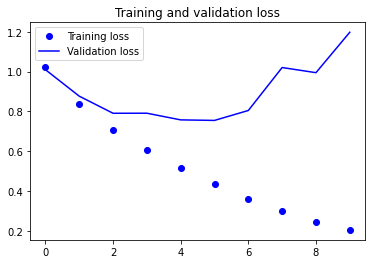

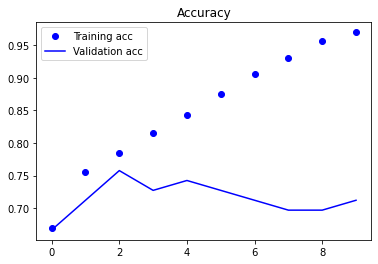

validating model model_checkpoints/resmodel_wb_cv10.best.hdf5
66/66 [==============================] - 2s 28ms/step
Test acc: 75.76%


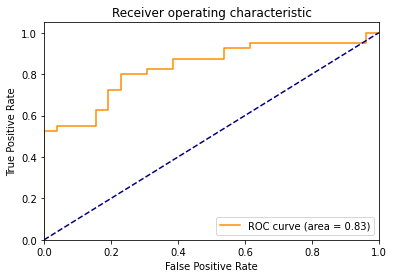

Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]
1    26
3    22
4    18
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.750
AUC for AD vs. CN = 0.936
confusion matrix
[[20  6]
 [ 0  0]
 [ 8 14]
 [ 2 16]]


In [9]:
# Split data into training/validation and holdout test data
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix

acc_AD, acc_MCI, auc_AD, auc_MCI = [], [], [], []
bacc_AD, bacc_MCI = [], []
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
f1_AD, f1_MCI = [], []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=np.random.RandomState(42)) # don't seed with integer to avoid interaction with tf.set_random_seed(k)
k = 1
for train_idX, test_idX in skf.split(X=images, y=grps.iloc[:, 0]): # split data as tenfold stratified cross-validation
    print('Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]')
    print(grps.iloc[train_idX, :].Group.value_counts())
    testgrps = grps.iloc[test_idX, :]
    print(list(testgrps.RID)) # print test RIDs
    print('Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]')
    print(testgrps.Group.value_counts())
    
    # Setup 3D CNN model
    tf.set_random_seed(k)
    input_shape = images.shape[1:]
    model = models.Sequential()

    # Convolution Layers
    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu',
              input_shape=input_shape, data_format='channels_last'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())
    
    # FC layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2'))

    opt = keras.optimizers.Adam(lr=0.0001) # learning_rate
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    if k==1:
        model.summary()
    
    # Assign trainset and testset
    traindat = images[train_idX, :]
    train_Y = labels[train_idX, :]
    testdat = images[test_idX, :]
    test_Y = labels[test_idX, :]
    
    # Perform data augmentation
    num_train_scans = traindat.shape[0]
    num_copies = 14
    traindatA = np.zeros((num_train_scans*num_copies,) + traindat.shape[1:], dtype=traindat.dtype)
    traindatA[0:num_train_scans, :, :, :, :] = traindat
    traindatA[num_train_scans:(2*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 1) # move around x-axis
    traindatA[2*num_train_scans:(3*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 1)
    traindatA[3*num_train_scans:(4*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 2) # move around y-axis
    traindatA[4*num_train_scans:(5*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 2)
    traindatLRshifted = np.fliplr(traindat) # flip L/R
    traindatA[5*num_train_scans:(6*num_train_scans), :, :, :, :] = traindatLRshifted
    traindatA[6*num_train_scans:(7*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 1) # move around x-axis
    traindatA[7*num_train_scans:(8*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 1)
    traindatA[8*num_train_scans:(9*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 2) # move around y-axis
    traindatA[9*num_train_scans:(10*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 2)
    traindatA[10*num_train_scans:(11*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 3) # move around z-axis
    traindatA[11*num_train_scans:(12*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 3)
    traindatA[12*num_train_scans:(13*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 3)
    traindatA[13*num_train_scans:(14*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 3)

    train_label = np.concatenate((train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y,
                                  train_Y, train_Y, train_Y, train_Y, train_Y, train_Y),
                                 axis=0)

    # Fit model to training data
    batch_size = 20
    epochs = 10 # validation accuracy doesn't increase any more after ~10 epochs
    filepath="model_checkpoints/resmodel_wb_cv%d-e{epoch:02d}-{val_acc:.2f}.hdf5" % k
    filepathbest="model_checkpoints/resmodel_wb_cv%d.best.hdf5" % k
    hist = model.fit(traindatA, train_label, batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(testdat, test_Y), shuffle=True,
                     callbacks=[
                        ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
                        ModelCheckpoint(filepathbest, monitor='val_acc', verbose=0, save_best_only=True, mode='max')],
                     class_weight=class_weights)
    # Display first models statistics
    from matplotlib import pyplot as plt
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    epochsr = range(len(loss))
    plt.figure()
    plt.plot(epochsr, loss, 'bo', label='Training loss')
    plt.plot(epochsr, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(epochsr, acc, 'bo', label='Training acc')
    plt.plot(epochsr, val_acc, 'b', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    #mymodel = hist.model
    #print('saving model to: models/resmodel_wb_cv%d.hdf5' % k)
    #mymodel.save('models/resmodel_wb_cv%d.hdf5' % k)
    print('validating model %s' % filepathbest)
    mymodel = models.load_model(filepathbest)
    
    # Calculate accuracy for the test data
    scores = mymodel.evaluate(testdat, test_Y, batch_size=batch_size) #, verbose=0
    print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))
    # Calculate area under the curve (AUC)
    # adapted from: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(testdat, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    testgrps = grps.iloc[test_idX, :]
    print('Distribution of diagnoses in test data: [1=CN, 3=LMCI, 4=AD]')
    print(testgrps.Group.value_counts())

    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [3,4]:
      grpi = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], _ = roc_curve(test_Y[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      acc[i] = np.mean((test_Y[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100

    print('AUC for MCI vs. CN = %0.3f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[4])
    auc_AD.append(roc_auc[4])
    auc_MCI.append(roc_auc[3])
    acc_AD.append(acc[4])
    acc_MCI.append(acc[3])
    print('confusion matrix')
    confmat = confusion_matrix(testgrps.Group-1, np.round(pred[:, 1]))
    print(confmat[:,(0,1)])
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    bacc_MCI.append(bacc); sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    bacc_AD.append(bacc); sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)

    k = k+1

In [10]:
# print model performance summary
from statistics import mean,stdev

print('Mean AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('Mean AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(acc_AD)))
print('Mean Bacc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(bacc_MCI), stdev(bacc_MCI)))
print('Mean Bacc for AD vs. CN = %0.3f +/- %0.3f' % (mean(bacc_AD), stdev(bacc_AD)))
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))

Mean AUC for MCI vs. CN = 0.785 +/- 0.078
Mean AUC for AD vs. CN = 0.949 +/- 0.029
Mean Acc for MCI vs. CN = 0.655 +/- 6.091
Mean Acc for AD vs. CN = 0.942 +/- 5.655
Mean Bacc for MCI vs. CN = 0.745 +/- 0.062
Mean Bacc for AD vs. CN = 0.889 +/- 0.053
Mean Sen for MCI vs. CN = 0.655 +/- 0.108
Mean Sen for AD vs. CN = 0.942 +/- 0.053
Mean Spec for MCI vs. CN = 0.836 +/- 0.081
Mean Spec for AD vs. CN = 0.836 +/- 0.081
Mean PPV for MCI vs. CN = 0.781 +/- 0.095
Mean PPV for AD vs. CN = 0.815 +/- 0.084
Mean NPV for MCI vs. CN = 0.741 +/- 0.063
Mean NPV for AD vs. CN = 0.952 +/- 0.043
Mean F1 for MCI vs. CN = 0.707 +/- 0.080
Mean F1 for AD vs. CN = 0.872 +/- 0.061


In [11]:
results = pd.DataFrame({'AUC_MCI':auc_MCI, 'Acc_MCI':acc_MCI, 'Bacc_MCI':bacc_MCI, 'f1_MCI':f1_MCI,
                        'sen_MCI':sen_MCI, 'spec_MCI':spec_MCI, 'ppv_MCI':ppv_MCI, 'npv_MCI':npv_MCI,
                        'AUC_AD':auc_AD, 'Acc_AD':acc_AD, 'Bacc_AD':bacc_AD, 'f1_AD':f1_AD,
                        'sen_AD':sen_AD, 'spec_AD':spec_AD, 'ppv_AD':ppv_AD, 'npv_AD':npv_AD})
print(results)
results.to_csv('results_xval_ADNI2_checkpoints.csv')

    AUC_MCI    Acc_MCI  Bacc_MCI    f1_MCI   sen_MCI  spec_MCI   ppv_MCI  \
0  0.781469  75.000000  0.744755  0.714286  0.681818  0.807692  0.750000   
1  0.753497  72.916667  0.729021  0.711111  0.727273  0.730769  0.695652   
2  0.741259  68.750000  0.676573  0.615385  0.545455  0.807692  0.705882   
3  0.896364  80.851064  0.798182  0.756757  0.636364  0.960000  0.933333   
4  0.667273  65.957447  0.650000  0.578947  0.500000  0.800000  0.687500   
5  0.872727  85.106383  0.843636  0.820513  0.727273  0.960000  0.941176   
6  0.869091  80.851064  0.811818  0.808511  0.863636  0.760000  0.760000   
7  0.694545  72.340426  0.712727  0.648649  0.545455  0.880000  0.800000   
8  0.820000  78.723404  0.780909  0.750000  0.681818  0.880000  0.833333   
9  0.750000  70.833333  0.702797  0.666667  0.636364  0.769231  0.700000   

    npv_MCI    AUC_AD     Acc_AD   Bacc_AD     f1_AD    sen_AD   spec_AD  \
0  0.750000  0.919028  82.222222  0.824899  0.800000  0.842105  0.807692   
1  0.760000